### Intro - Visual Cortex
* [LeNet-5 paper](http://goo.gl/A347S4) - intro'd convo & pooling layers

In [1]:
%%html
<style>
table,td,tr,th {border:none!important}
</style>

In [2]:
# utilities
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

### Convolutional Layers
* [math detail](http://goo.gl/HAfxXd)
* neurons connected to receptor field in next layer. uses *zero padding* to force layers to have same height & width.
* also can connect large input layer to much smaller layer by spacing out receptor fields (distance between receptor fields = *stride*)

Layers | Padding | Strides
- | - | -
![alt](pics/cnn-layers.png) | ![alt](pics/zero-padding.png) | ![alt](pics/strides.png)

### Filters
* neuron weights can look like small image (w/ size = receptor field)
* examples given: 
    1) vertical filter (single vertical bar, mid-image, all other cells zero)
    2) horizontal filter (single horizontal bar, mid-image, all other cells zero)
* both return **feature maps** (highlights areas of image most similar to filter)
![filters to feature maps](pics/filters.png)

[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


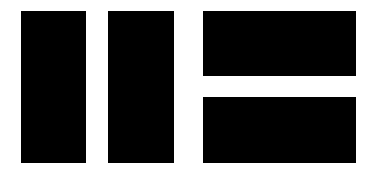

In [3]:
import numpy as np

fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
print(fmap[:, :, 0, 0])
print(fmap[:, :, 0, 1])

plt.figure(figsize=(6,6))

plt.subplot(121)
plot_image(fmap[:, :, 0, 0])
plt.subplot(122)
plot_image(fmap[:, :, 0, 1])
plt.show()

In [4]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

image = china[150:220, 130:250]
height, width, channels = image.shape

image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

In [5]:
import tensorflow as tf

tf.reset_default_graph()

# Define the model

X = tf.placeholder(
    tf.float32, 
    shape=(None, height, width, 1))

feature_maps = tf.constant(fmap)

convolution = tf.nn.conv2d(
    X, 
    feature_maps, 
    strides=[1,1,1,1], 
    padding="SAME", 
    use_cudnn_on_gpu=False)

In [6]:
# Run the model

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

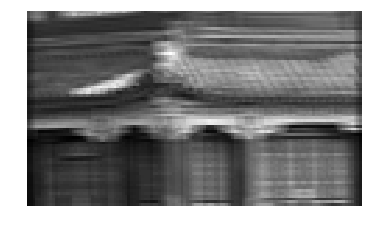

In [7]:
plt.figure(figsize=(6,6))

#plt.subplot(121)
plot_image(images[0, :, :, 0])
#plt.subplot(122)
plot_image(output[0, :, :, 0])
#plt.subplot(123)
plot_image(output[0, :, :, 1])
plt.show()

In [8]:
%%html
<style>
img[alt=stacking] { width: 400px; }
</style>

### Stacking Feature Maps
* images made of *sublayers* (one per color channel, typical red/green/blue, grayscale = one chan, others = many chans)
![stacking](pics/stacking-feature-maps.png)

In [9]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
dataset = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters_test = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters_test[:, 3, :, 0] = 1 # vertical line
filters_test[3, :, :, 1] = 1 # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, 
                   shape=(None, height, width, channels))

convolution = tf.nn.conv2d(
    X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1])
plt.show()

NameError: name 'filters' is not defined

In [26]:
%%html
<style>
img[alt=padding] { width: 400px; }
</style>

### "Valid" v. "Same" Padding
![padding](pics/padding-options.png)

In [27]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

filter_primes = np.array(
    [2., 3., 5., 7., 11., 13.], 
    dtype=np.float32)

x = tf.constant(
    np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))

print ("x:\n",x)

filters = tf.constant(
    filter_primes.reshape(1, 6, 1, 1))

# conv2d arguments:
# x = input minibatch = 4D tensor
# filters = 4D tensor
# strides = 1D array (1, vstride, hstride, 1)
# padding = VALID = no zero padding, may ignore edge rows/cols
# padding = SAME  = zero padding used if needed

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv =  tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

x:
 Tensor("Const:0", shape=(1, 1, 13, 1), dtype=float32)
VALID:
 [[[[ 184.]
   [ 389.]]]]
SAME:
 [[[[ 143.]
   [ 348.]
   [ 204.]]]]


### Pooling Layers
* Goal: subsample (shrink) input image to reduce loading.
* Need to define pool size, stride & padding type.
* Result: aggregation function (max, mean)
* Below: max pool, 2x2, stride = 2, no padding.
![pooling layer](pics/pooling-layer.png)

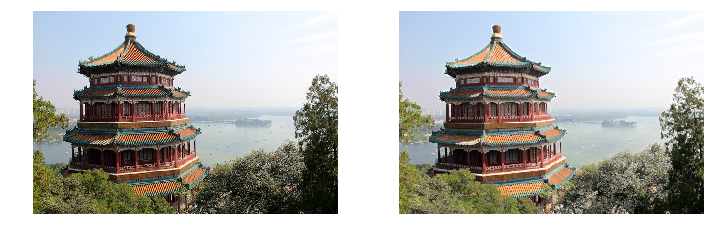

In [28]:
dataset = np.array([china, flower], dtype=np.float32)

batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, 
                   shape=(None, height, width, channels))

# alternative: avg_pool()

max_pool = tf.nn.max_pool(
    X, 
    ksize=[1, 2, 2, 1], 
    strides=[1,2,2,1], 
    padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.figure(figsize=(12,12))
plt.subplot(121)
plot_color_image(dataset[0])
plt.subplot(122)
plot_color_image(output[0])
plt.show()

### Memory Requirements
* Main memory killer: reverse pass of backprop - needs all intermediate vals computed during forward pass
* Example CNN:
    * 5x5 filters outputting 200 feature maps (size 150,100)
    * stride = 1, "SAME" padding
    * If image = 150x100x3 (RGB), then
    * params_count = (5x5x3+1) * 200 = 15,200 
    * 200 feature maps contain 150 x 100 neurons => each needs to compute weighted sum of 5x5x3 = 75 inputs => 225M floating-point multiplies.
    * If using 32b float => output requires 200x150x100x32 = 96M bits = 11.4MB for one instance

#### During inference: one layer's memory can be dropped when next layer is computed. (You only need enough memory for two layers).
#### During training: all computed values have to preserved for reverse pass (You need enough memory for all layers.)

### CNN Architectures

#### [LeNet-5](http://yann.lecun.com/) (c. 1998, used to solve MNIST digits dataset)
![layers](pics/lenet-5.png)
* MNIST images zero-padded to 32x32 & normalized
* pooling layers: mean x learned coefficient + learnable bias
* output layer: output = Euclidian distance (input vect, weight vect)

#### [AlexNet](http://goo.gl/mWRBRp) won ILSVRC 2012
![layers](pics/alexnet.png)
* Uses 50% dropout on layers F8, F9 for regularization
* Uses random image shifts/flips/rotates/lighting to augment dataset
* Uses *local response normalization* on layers C1, C3.
* Hyperparameter settings: r=2, alpha=0.00002, beta=0.75, k=1
* ZFNet (tweaked AlexNet) won ILSVRC 2013.

#### [GoogLeNet](http://goo.gl/tCFzVs) won ILSVRC 2014
* Much deeper than previous nets
* Uses *inception modules* to use params much more efficiently. They use 1x1 kernels as "bottleneck layers" (reduces dimensionality). Also: pairs of convo layers act as single more powerful convo layer.
* All convo layers use ReLU activation.
![inception](pics/inception.png)
![googlenet](pics/googlenet.png)

#### [ResNet](http://goo.gl/4puHU5) 
* 152 layers deep
* Uses *skip connections* to connect non-adjacent layers in stack
* skip connections force learning model f(x) = h(x) - x (*residual learning*). When initialized, weights near zero => network outputs values near-copy of inputs (identity function).
![residual](pics/residual-learning.png)
* architecture: stack starts & ends like GoogLeNet, stack of residual units in between.
![resnet](pics/resnet.png)

### TF Convolution Ops

* conv1d() - 1D layer - good for NLP
* conv3d() - 3D layer - good for PET scans
* atrous_conv2D() - 2D layer with "holes"
* conv2d_transpose() - 2D "deconvolutional layer" - upsamples image by inserting zeroes * between inputs
* depthwise_conv2d() - applies every filter to each input channel independently
* separable_conv2d() - depthwise convo, then apply 1x1 CNN layer to result